<a href="https://colab.research.google.com/github/deding2000/COMP5329_Ass2/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Not needed before we upload files to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
uploaded = files.upload() # select all python files from the github page and kaggle.json

Saving Dataload.py to Dataload.py
Saving kaggle.json to kaggle.json
Saving metrics.py to metrics.py
Saving models.py to models.py
Saving norm_samples_weight_full.pt to norm_samples_weight_full.pt
Saving norm_samples_weight_subset.pt to norm_samples_weight_subset.pt
Saving subset_train_indices.npy to subset_train_indices.npy
Saving unnorm_samples_weight_full.pt to unnorm_samples_weight_full.pt
Saving unnorm_samples_weight_subset.pt to unnorm_samples_weight_subset.pt
Saving utils.py to utils.py
Saving validation_indices.npy to validation_indices.npy


In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'multi-label-classification-competition-2025'
! mkdir Dataset
! unzip multi-label-classification-competition-2025.zip -d Dataset &> /dev/null

 98% 389M/399M [00:00<00:00, 1.36GB/s]
100% 399M/399M [00:00<00:00, 1.35GB/s]


Defining model arcitechture

In [5]:
# Model arcitechture
import torch.nn.functional as F
from torch import nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()  # Compulsory operation.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=8, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8,16, 5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16,32,3, stride=1,padding=1)
        self.conv4 = nn.Conv2d(32,16,3, stride=1,padding=1)
        self.pool1 = nn.MaxPool2d(2,stride=2)
        self.pool2 = nn.MaxPool2d(3,stride=2)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(16)
        self.bn5 = nn.BatchNorm1d(1000)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.dropout3 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(3600,1000)
        self.fc2 = nn.Linear(1000, 18)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool1(F.relu(self.bn4(self.conv4(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout3(x)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout3(x)
        logits = self.fc2(x)
        return logits

Setup dataloaders and initialize model

In [8]:
import re
import pandas as pd
from io import StringIO
import os
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split, WeightedRandomSampler

from Dataload import pil_process_image_color, encode, CustomImageDataset
from utils import train_network, pos_weight, test
from metrics import compute_metrics
from sklearn.metrics import confusion_matrix
import torch
import numpy as np
from tqdm import tqdm

# Hyperparameters
batch_size = 256
lr = 0.0001
weight_decay = 0
INPUT_HEIGHT = 256
INPUT_WIDTH = 256

Normalize_weights = True

# Set device to GPU if this is available
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')

# Loading filenames and labels
# Assumes data is in folder "Dataset"
DATASET_PATH = "/content/Dataset/COMP5329S1A2Dataset/"
FILENAME_TRAIN = 'train.csv'
FILENAME_TEST = 'test.csv'

with open(DATASET_PATH + FILENAME_TRAIN) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
with open(DATASET_PATH + FILENAME_TEST) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
df_train.to_csv("train_labels_captions.csv")
df_test.to_csv("test_labels_captions.csv")

# Defining transforms
resize = transforms.Resize(size=(INPUT_HEIGHT,
        INPUT_WIDTH)) # For resizing images to square

# Transform to use on common class
trainTransforms_basic = transforms.Compose(
    [resize,transforms.ToTensor()
    ,transforms.Normalize(mean=[0.3598, 0.3480, 0.3270], std=[0.1929, 0.1884, 0.1901])])
# Data augmentation for uncommon class
trainTransforms_augment = transforms.Compose(
    [resize,transforms.RandomHorizontalFlip(),transforms.RandomAffine(degrees=30),
     transforms.RandomCrop(size=256,pad_if_needed=True),transforms.ColorJitter(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.3598, 0.3480, 0.3270], std=[0.1929, 0.1884, 0.1901])])
# Transform for test images
testTransforms = transforms.Compose([resize,transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4652, 0.4492, 0.4214], std=[0.2317, 0.2265, 0.2303])])

# Sampling method
if Normalize_weights:
  # Calculate weights for loss function
  c_weights = pos_weight(df_train,barplot=False,normalize=True)
  samples_weight = torch.load("/content/norm_samples_weight_full.pt") # Sample common class less
else:
  c_weights = pos_weight(df_train,barplot=False,normalize=False)
  samples_weight = torch.load("/content/unnorm_samples_weight_full.pt") # Sample common class less

weighted_sampler_full = WeightedRandomSampler(samples_weight, len(samples_weight))

# Create dataloaders
training_data = CustomImageDataset(df_train,DATASET_PATH+"data/",transform=trainTransforms_basic,transform_aug=trainTransforms_augment,target_transform=encode)
test_data = CustomImageDataset(df_test,DATASET_PATH+"data/",transform=testTransforms,target_transform=None,targets_available=False)
train_dataloader = DataLoader(training_data, batch_size=batch_size, sampler=weighted_sampler_full) #Instead of shuffle = True
test_dataloader = DataLoader(test_data,shuffle=False)

# Setup model
model = CNN().to(device)

# Use BCE loss
loss = torch.nn.BCEWithLogitsLoss(c_weights.to(device))
# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
print('Model initialized.')

mean = 0.
std = 0.
for images, _ in train_dataloader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(training_data)
std /= len(training_data)
print(mean)
print()
print(std)


We are using GPU.
Class counts: tensor([22794.,  1162.,  4364.,  1272.,  1130.,  1394.,  1221.,  2210.,  1042.,
         1471.,   604.,   605.,   251.,  1934.,  1099.,  1430.,  1525.,  1020.],
       dtype=torch.float64)
Class weights: tensor([0.0110, 0.2160, 0.0575, 0.1973, 0.2221, 0.1801, 0.2056, 0.1136, 0.2409,
        0.1706, 0.4156, 0.4149, 1.0000, 0.1298, 0.2284, 0.1755, 0.1646, 0.2461],
       dtype=torch.float64)
Model initialized.
tensor([0.3598, 0.3480, 0.3270])

tensor([0.1929, 0.1884, 0.1901])


In [9]:
mean = 0.
std = 0.
for images, _ in test_dataloader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(test_data)
std /= len(test_data)
print(mean)
print()
print(std)

tensor([0.4652, 0.4492, 0.4214])

tensor([0.2317, 0.2265, 0.2303])


Training on subset of all data and compute metrics for validation set

  0%|          | 0/15 [00:00<?, ?it/s]


Train Epoch: 0 [0/23996 (0%)]	Loss: 0.178785

Train Epoch: 0 [12800/23996 (53%)]	Loss: 0.082058


  7%|▋         | 1/15 [01:35<22:14, 95.33s/it]


Test set results: Average loss: 0.0638, F1 Score: 0.60

Train Epoch: 1 [0/23996 (0%)]	Loss: 0.074417

Train Epoch: 1 [12800/23996 (53%)]	Loss: 0.071382


 13%|█▎        | 2/15 [03:08<20:24, 94.22s/it]


Test set results: Average loss: 0.0492, F1 Score: 0.62

Train Epoch: 2 [0/23996 (0%)]	Loss: 0.068760

Train Epoch: 2 [12800/23996 (53%)]	Loss: 0.071018


 20%|██        | 3/15 [04:43<18:55, 94.65s/it]


Test set results: Average loss: 0.0459, F1 Score: 0.62

Train Epoch: 3 [0/23996 (0%)]	Loss: 0.071281

Train Epoch: 3 [12800/23996 (53%)]	Loss: 0.065899


 27%|██▋       | 4/15 [06:18<17:22, 94.79s/it]


Test set results: Average loss: 0.0420, F1 Score: 0.62

Train Epoch: 4 [0/23996 (0%)]	Loss: 0.064079

Train Epoch: 4 [12800/23996 (53%)]	Loss: 0.064070


 33%|███▎      | 5/15 [07:53<15:48, 94.84s/it]


Test set results: Average loss: 0.0425, F1 Score: 0.63

Train Epoch: 5 [0/23996 (0%)]	Loss: 0.064646

Train Epoch: 5 [12800/23996 (53%)]	Loss: 0.065142


 40%|████      | 6/15 [09:29<14:17, 95.23s/it]


Test set results: Average loss: 0.0401, F1 Score: 0.63

Train Epoch: 6 [0/23996 (0%)]	Loss: 0.063698

Train Epoch: 6 [12800/23996 (53%)]	Loss: 0.067859


 47%|████▋     | 7/15 [11:05<12:42, 95.29s/it]


Test set results: Average loss: 0.0417, F1 Score: 0.63

Train Epoch: 7 [0/23996 (0%)]	Loss: 0.068748

Train Epoch: 7 [12800/23996 (53%)]	Loss: 0.063044


 53%|█████▎    | 8/15 [12:39<11:05, 95.02s/it]


Test set results: Average loss: 0.0412, F1 Score: 0.63

Train Epoch: 8 [0/23996 (0%)]	Loss: 0.069544

Train Epoch: 8 [12800/23996 (53%)]	Loss: 0.062039


 60%|██████    | 9/15 [14:12<09:25, 94.29s/it]


Test set results: Average loss: 0.0405, F1 Score: 0.63

Train Epoch: 9 [0/23996 (0%)]	Loss: 0.062715

Train Epoch: 9 [12800/23996 (53%)]	Loss: 0.061152


 67%|██████▋   | 10/15 [15:45<07:49, 93.88s/it]


Test set results: Average loss: 0.0402, F1 Score: 0.63

Train Epoch: 10 [0/23996 (0%)]	Loss: 0.061162

Train Epoch: 10 [12800/23996 (53%)]	Loss: 0.060308


 73%|███████▎  | 11/15 [17:17<06:13, 93.40s/it]


Test set results: Average loss: 0.0389, F1 Score: 0.63

Train Epoch: 11 [0/23996 (0%)]	Loss: 0.057079

Train Epoch: 11 [12800/23996 (53%)]	Loss: 0.058351


 80%|████████  | 12/15 [18:49<04:39, 93.02s/it]


Test set results: Average loss: 0.0400, F1 Score: 0.63

Train Epoch: 12 [0/23996 (0%)]	Loss: 0.061834

Train Epoch: 12 [12800/23996 (53%)]	Loss: 0.064986


 87%|████████▋ | 13/15 [20:21<03:05, 92.63s/it]


Test set results: Average loss: 0.0395, F1 Score: 0.63

Train Epoch: 13 [0/23996 (0%)]	Loss: 0.056183

Train Epoch: 13 [12800/23996 (53%)]	Loss: 0.060461


 93%|█████████▎| 14/15 [21:53<01:32, 92.56s/it]


Test set results: Average loss: 0.0389, F1 Score: 0.63

Train Epoch: 14 [0/23996 (0%)]	Loss: 0.060668

Train Epoch: 14 [12800/23996 (53%)]	Loss: 0.057953


100%|██████████| 15/15 [23:25<00:00, 93.70s/it]


Test set results: Average loss: 0.0391, F1 Score: 0.63


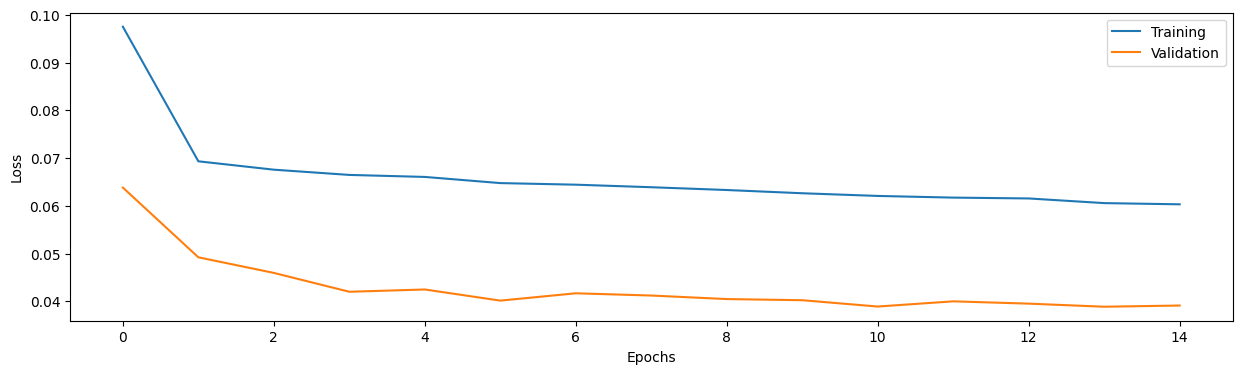


Test set results: Average loss: 0.0392, F1 Score: 0.63
Full Metrics
{'F1_score': 0.6251803525500284, 'accuracy': 0.944675925925926, 'precision': 0.7420699925539836, 'recall': 0.5401040537611099}


In [ ]:
# Loading indices for 80/20 split of training data
train_idx = np.load("/content/subset_train_indices.npy")
validation_idx = np.load("/content/validation_indices.npy")
# Loading sample weights to sample some classes more than others

if Normalize_weights:
  samples_weight_subset = torch.load("/content/norm_samples_weight_subset.pt")
else:
  samples_weight_subset = torch.load("/content/unnorm_samples_weight_subset.pt") # Sample common class less

weigthed_sampler_subset = WeightedRandomSampler(samples_weight_subset,len(samples_weight_subset))

# Subset dataset for train and val
subset_train_dataset = Subset(training_data, train_idx)
validation_dataset = Subset(training_data, validation_idx)
subset_train_loader = DataLoader(subset_train_dataset, batch_size=batch_size,sampler=weigthed_sampler_subset) #shuffle=True)
validation_loader = DataLoader(validation_dataset, shuffle=False)

# Training
log_interval = 50 # How often we print train loss
train_losses, test_losses = train_network(log_interval,model, device, subset_train_loader, validation_loader,optimizer, loss,epochs=15)

plt.figure(figsize=(15,4))
plt.plot(train_losses,label="Training")
plt.plot(test_losses,label="Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.show()

# Set thresholds for predictions
thresholds = [0.5]*18

# Testing on validation set and compute metrics
test_loss, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True) # output predictions as tensors
all_preds = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_preds])
all_targets = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_targets])
#for label in range(1,19): # remember that 12 is deleted!
#   print("Metrics for class {}".format(label))
#   print(compute_metrics(all_preds.squeeze()[:,label-1],all_targets.squeeze()[:,label-1]))
print("Full Metrics")
print(compute_metrics(all_preds,all_targets))

Tuning of thresholds

In [ ]:
threshold_values = [0.5,0.45,0.4,0.35,0.3]
validation_loader = DataLoader(validation_dataset, shuffle=False)
thresholds = [0.5]*19
best_thresholds = []
for label in range(1,19): # remember that class 12 is deleted!
    print("Searching for label {}".format(label))
    best_F1 = 0
    for idx in range(len(threshold_values)):
        thresholds[label-1] = threshold_values[idx]
        _, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True) # output predictions as tensors
        all_preds = np.asarray([pred.cpu() for pred in all_preds])
        all_targets = np.asarray([targ.cpu() for targ in all_targets])
        F1_score = compute_metrics(all_preds,all_targets)["F1_score"]
        if F1_score > best_F1:
            best_F1 = F1_score
            best_threshold = threshold_values[idx]
            best_thresholds.append(best_threshold)
    print("Found best F1: {}".format(best_F1))
    print("Found best threshold {}".format(best_threshold))
    thresholds[label-1] = best_threshold
print("Final Thresholds = {}".format(thresholds))

Searching for label 2
Found best F1: 0.663791884631698
Found best threshold 0.35
Searching for label 3
Found best F1: 0.6667128987517337
Found best threshold 0.3
Searching for label 4
Found best F1: 0.6674057649667406
Found best threshold 0.4
Searching for label 5
Found best F1: 0.6662981898576759
Found best threshold 0.45
Searching for label 6
Found best F1: 0.6675383662514623
Found best threshold 0.3
Searching for label 7
Found best F1: 0.667125740256163
Found best threshold 0.5
Searching for label 8
Found best F1: 0.6689636163175302
Found best threshold 0.4
Searching for label 9
Found best F1: 0.6685509444367848
Found best threshold 0.3
Searching for label 10
Found best F1: 0.6677197802197802
Found best threshold 0.35
Searching for label 11
Found best F1: 0.6664835542127308
Found best threshold 0.4
Searching for label 12
Found best F1: 0.6675839295542102
Found best threshold 0.4
Searching for label 13
Found best F1: 0.6680423717155042
Found best threshold 0.4
Searching for label 14


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-71-bcc6e729e3f2>", line 10, in <cell line: 0>
    _, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True) # output predictions as tensors
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-62-e17ac7eb4db6>", line 20, in test
    for data, target in (test_loader):  # Iterate through the entire test set.
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 708, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 764, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may r

Check model size and save temporary model

Model saved to /content/model_23_05_25_sampling-weighting_v2.pt
Model size: 13.887401580810547 MB


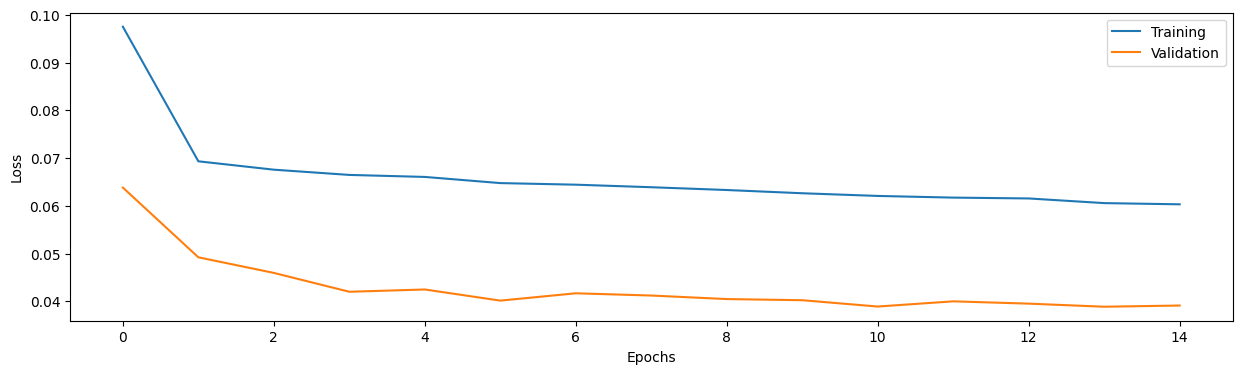

In [ ]:
# save model, scores and plot and check size of model is under 100MB
model_name = "23_05_25_sampling-weighting_v2"

path_name_model = "/content/model_" + model_name+".pt"
path_name_plot = "/content/model_" + model_name + "_losscurve.png"
path_name_scores = "/content/model_" + model_name + "_scores.txt"

torch.save(model.state_dict(), path_name_model)
print(f"Model saved to {path_name_model}")
size_mb = os.path.getsize(path_name_model) / (1024 * 1024)
print(f"Model size: {size_mb} MB")

plt.figure(figsize=(15,4))
plt.plot(train_losses,label="Training")
plt.plot(test_losses,label="Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.savefig(path_name_plot)

import json
with open(path_name_scores, 'w') as file:
     file.write(json.dumps(compute_metrics(all_preds,all_targets)))

Train model on entire training set and compute predictions

Full Model initialized.


  0%|          | 0/20 [00:00<?, ?it/s]


Train Epoch: 0 [0/29996 (0%)]	Loss: 0.171917

Train Epoch: 0 [12800/29996 (53%)]	Loss: 0.057527


  5%|▌         | 1/20 [01:04<20:23, 64.38s/it]


Train Epoch: 1 [0/29996 (0%)]	Loss: 0.039425

Train Epoch: 1 [12800/29996 (53%)]	Loss: 0.033966


 10%|█         | 2/20 [02:07<19:09, 63.89s/it]


Train Epoch: 2 [0/29996 (0%)]	Loss: 0.034816

Train Epoch: 2 [12800/29996 (53%)]	Loss: 0.033357


 15%|█▌        | 3/20 [03:11<18:01, 63.63s/it]


Train Epoch: 3 [0/29996 (0%)]	Loss: 0.033825

Train Epoch: 3 [12800/29996 (53%)]	Loss: 0.032225


 20%|██        | 4/20 [04:15<16:58, 63.69s/it]


Train Epoch: 4 [0/29996 (0%)]	Loss: 0.032075

Train Epoch: 4 [12800/29996 (53%)]	Loss: 0.035531


 25%|██▌       | 5/20 [05:18<15:52, 63.50s/it]


Train Epoch: 5 [0/29996 (0%)]	Loss: 0.027573

Train Epoch: 5 [12800/29996 (53%)]	Loss: 0.030430


 30%|███       | 6/20 [06:21<14:48, 63.49s/it]


Train Epoch: 6 [0/29996 (0%)]	Loss: 0.034065

Train Epoch: 6 [12800/29996 (53%)]	Loss: 0.034331


 35%|███▌      | 7/20 [07:24<13:43, 63.34s/it]


Train Epoch: 7 [0/29996 (0%)]	Loss: 0.031704

Train Epoch: 7 [12800/29996 (53%)]	Loss: 0.029356


 40%|████      | 8/20 [08:28<12:41, 63.46s/it]


Train Epoch: 8 [0/29996 (0%)]	Loss: 0.034292

Train Epoch: 8 [12800/29996 (53%)]	Loss: 0.033718


 45%|████▌     | 9/20 [09:31<11:38, 63.49s/it]


Train Epoch: 9 [0/29996 (0%)]	Loss: 0.030549

Train Epoch: 9 [12800/29996 (53%)]	Loss: 0.031615


 50%|█████     | 10/20 [10:35<10:34, 63.47s/it]


Train Epoch: 10 [0/29996 (0%)]	Loss: 0.028386

Train Epoch: 10 [12800/29996 (53%)]	Loss: 0.030027


 55%|█████▌    | 11/20 [11:38<09:30, 63.39s/it]


Train Epoch: 11 [0/29996 (0%)]	Loss: 0.027979

Train Epoch: 11 [12800/29996 (53%)]	Loss: 0.024163


 60%|██████    | 12/20 [12:41<08:26, 63.31s/it]


Train Epoch: 12 [0/29996 (0%)]	Loss: 0.028221

Train Epoch: 12 [12800/29996 (53%)]	Loss: 0.025168


 65%|██████▌   | 13/20 [13:44<07:22, 63.26s/it]


Train Epoch: 13 [0/29996 (0%)]	Loss: 0.026107

Train Epoch: 13 [12800/29996 (53%)]	Loss: 0.028584


 70%|███████   | 14/20 [14:48<06:19, 63.26s/it]


Train Epoch: 14 [0/29996 (0%)]	Loss: 0.026192

Train Epoch: 14 [12800/29996 (53%)]	Loss: 0.030884


 75%|███████▌  | 15/20 [15:51<05:16, 63.27s/it]


Train Epoch: 15 [0/29996 (0%)]	Loss: 0.031845

Train Epoch: 15 [12800/29996 (53%)]	Loss: 0.033709


 80%|████████  | 16/20 [16:54<04:13, 63.28s/it]


Train Epoch: 16 [0/29996 (0%)]	Loss: 0.029324

Train Epoch: 16 [12800/29996 (53%)]	Loss: 0.029831


 85%|████████▌ | 17/20 [17:57<03:09, 63.22s/it]


Train Epoch: 17 [0/29996 (0%)]	Loss: 0.029518

Train Epoch: 17 [12800/29996 (53%)]	Loss: 0.026570


 90%|█████████ | 18/20 [19:00<02:06, 63.18s/it]


Train Epoch: 18 [0/29996 (0%)]	Loss: 0.029473

Train Epoch: 18 [12800/29996 (53%)]	Loss: 0.028325


 95%|█████████▌| 19/20 [20:04<01:03, 63.21s/it]


Train Epoch: 19 [0/29996 (0%)]	Loss: 0.032103

Train Epoch: 19 [12800/29996 (53%)]	Loss: 0.025974


100%|██████████| 10000/10000 [00:38<00:00, 262.07it/s]



Predictions computed for test set.


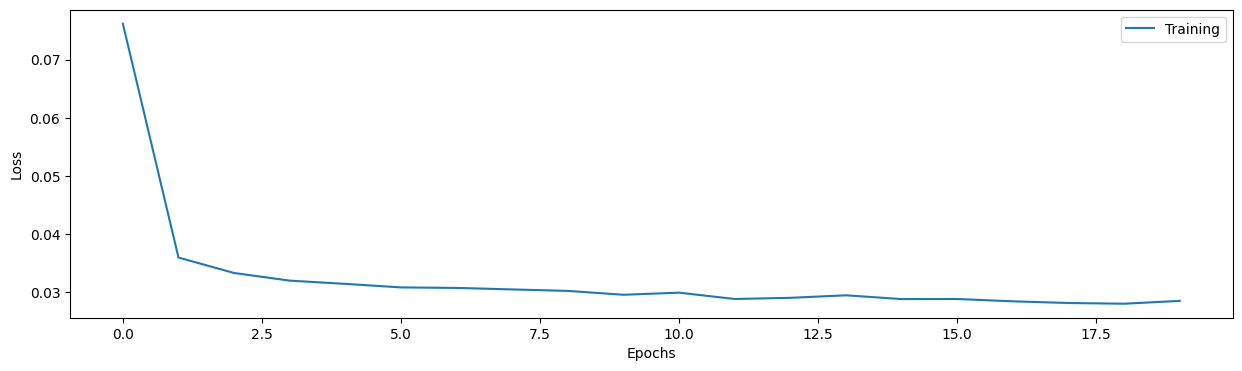

In [ ]:
# Training new model on the full dataset
model_full = CNN().to(device)
c_weights_full = c_weights.to(device)
loss_full = torch.nn.BCEWithLogitsLoss(c_weights_full)
optimizer_full = torch.optim.Adam(model_full.parameters(), lr=lr)
print('Full Model initialized.')
log_interval = 50 # How often we print train loss
train_losses_full = train_network(log_interval,model_full, device, train_dataloader, test_loader=0,optimizer=optimizer_full, loss=loss,epochs=20)

plt.figure(figsize=(15,4))
plt.plot(train_losses_full,label="Training")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')

# Compute predictions for true test set
thresholds_full = [0.5]*18
test_pred_full = test(model_full, device, test_dataloader,loss,thresholds=thresholds_full,target_available=False)

Save full model, check size and get predictions

Full Model saved to /content/model_23_05_25_sampling-weighting_v2_full.pt
Full Model size: 13.88820743560791 MB
Submission dataframe:
<bound method NDFrame.describe of         ImageID Labels
0     30000.jpg      1
1     30001.jpg      1
2     30002.jpg      1
3     30003.jpg      1
4     30004.jpg      1
...         ...    ...
9995  39995.jpg      1
9996  39996.jpg      1
9997  39997.jpg      1
9998  39998.jpg      1
9999  39999.jpg      1

[10000 rows x 2 columns]>
Predictions saved as /content/submission_newest.csv


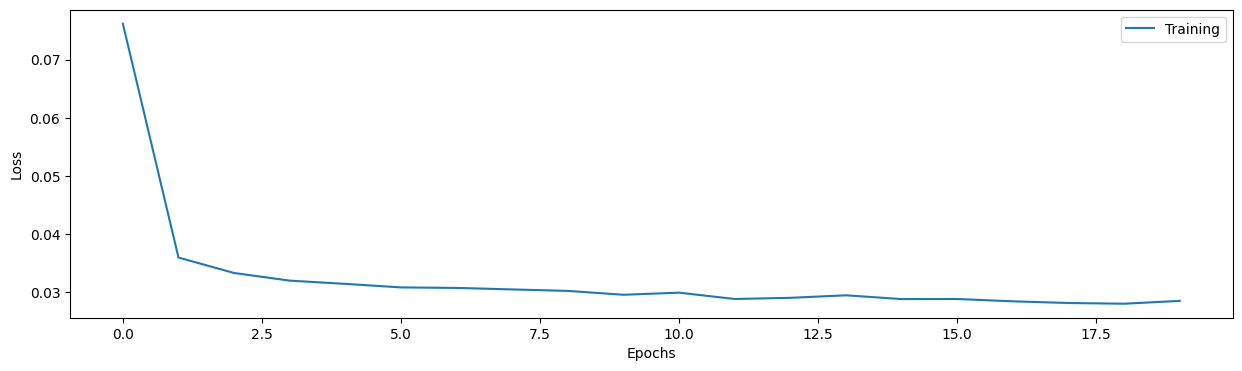

In [ ]:
# Convert predictions to csv
from tqdm import tqdm
import numpy as np

#test_pred_full = test(model_full, device, test_dataloader,loss,thresholds=thresholds_full,target_available=False)
#print(test_pred_full)

def get_class(array):
  class_pred = np.where(array > 0.5)[1] + 1
  for i in range(len(class_pred)):
    if class_pred[i] >= 12:
      class_pred += 1
  return class_pred

def unencode(y_pred,to_cpu=True):
  labels = []
  for i in range(len(y_pred)):
    if to_cpu: # Move to cpu device
      temp = y_pred[i].cpu()
    temp = np.asarray(temp)
    temp = get_class(temp)
    temp = " ".join(str(item) for item in temp)
    labels.append(temp)
  return labels

# Save full model
path_name_model = "/content/model_" + model_name+ "_full.pt"
path_name_plot = "/content/model_" + model_name + "_losscurve_full.png"

torch.save(model_full.state_dict(), path_name_model)
print(f"Full Model saved to {path_name_model}")
size_mb = os.path.getsize(path_name_model) / (1024 * 1024)
print(f"Full Model size: {size_mb} MB")

plt.figure(figsize=(15,4))
plt.plot(train_losses_full,label="Training")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.savefig(path_name_plot)

#Save predictions in csv
pred_labels= unencode(test_pred_full)
pred_df = df_test.copy()
pred_df = pred_df.drop("Caption",axis=1)
pred_df["Labels"] = pred_labels
print("Submission dataframe:")
print(pred_df.describe)
submission_name = "/content/submission_newest.csv"
pred_df.to_csv(submission_name,index=False)
print(f"Predictions saved as {submission_name}")

In [ ]:
# Submit predictions
! kaggle competitions submit -c multi-label-classification-competition-2025 -f /content/submission_newest.csv -m "playing with sampling label 12 driller ikke?"

100% 117k/117k [00:00<00:00, 129kB/s]
Successfully submitted to Multi-label Classification Competition 2025